# Mapping the Latent Space of CXR Patient Geometry
## Zebrastack V0 VAE trained on the CovidNet chest radiograph dataset
The zebrastack is a variational auto-encoder that is _very_ roughly aligned with the distributed hierarchical architecture + shifter circuit.  Here it is applied to recognition of the CovidNet chest radiograph dataset.

First, declare some helper pyplot functions to show us thumbnails.

In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many figures we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

## Preparing the CovidNet dataset
Now import the CovidNet data and pre-process by:
* converting to grayscale (some CovidNet images are RGB)
* apply a small-window CLAHE
* resize to standard size
* whiten

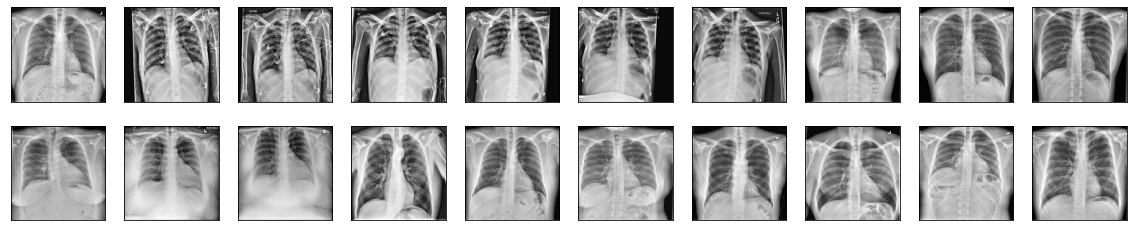

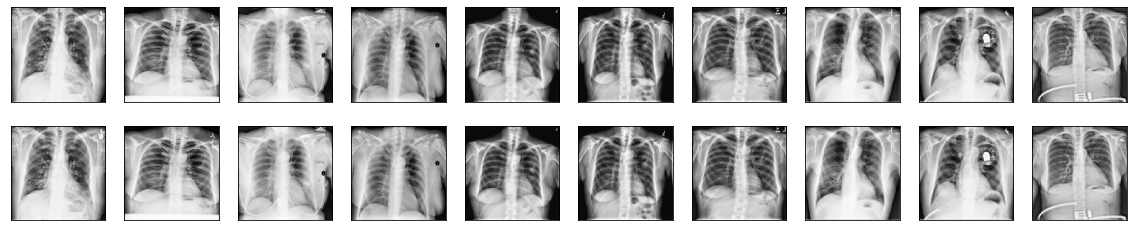

In [3]:
import glob
# pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
pngs = glob.glob("g:/DataAll/chest-nihcc/by_class/no_finding/*.png")

import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

import imageio
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from IPython.display import clear_output

sz = 128
imgs = []
for png in pngs:
    if len(imgs) % 100 == 0:
        clear_output(True)
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
        if len(imgs) > 10:
            show_original_decoded(imgs[-11:-1], imgs[-21:-11], sz)
    img = imageio.imread(png)
    if len(img.shape) > 2:
        img = rgb2gray(img)
        img = img_as_ubyte(img)
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
    
show_original_decoded(imgs[:10], imgs[:10], sz)

Partition the data in to train and test: 90% train and 10% test.  We are assuming all images are from distinct patients, so there is no need to partition by subject.

In [4]:
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(54325, 128, 128, 1) (6036, 128, 128, 1)


## Defining the Variational Autoencoder
To defined the variational autoencoder, we need to helper functions:
* A function for reparameterized sampling
* A function for KLDiv loss

In [5]:
def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
use_mse = True # False
def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """
    Compute VAE loss, using either mse or crossentropy.
    # Arguments
        z_mean: mean of Q(z|X)
        z_log_var: log variance of Q(z|X)
        y_true, y_pred: truth and predicated values
    # Returns
        loss value
    """
    from tensorflow.keras.losses import mse, binary_crossentropy
    from keras import backend as K
    img_pixels = sz * sz
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

We create the Keras model in three parts: 
* encode_only: the recognition subsystem(encoder)
* decode_only: decoder
* autoencoder: the full system

Parameters that control the model are:
* sz: size x size of inputs
* latent_dim: latent dimension at the pulvinar

The layers are named to suggest correspondence between each layer and an area in the distributed hierarchy model / shifter circuit.

In [7]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras import backend as K

latent_dim = 12
plot_model = False
cit_decimate = False
act_func = 'softplus' # or 'relu'

# create encoder side
retina = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))

v1_conv2d = Conv2D(16, (5,5), name='v1_conv2d', activation=act_func, padding='same')(retina)
v1_maxpool = MaxPooling2D((2,2), name='v1_maxpool', padding='same')(v1_conv2d)
v1_dropout = SpatialDropout2D(0.1, name='v1_dropout')(v1_maxpool)

v2_conv2d = Conv2D(16, (3,3), name='v2_conv2d', activation=act_func, padding='same')(v1_dropout)
v2_maxpool = MaxPooling2D((2,2), name='v2_maxpool', padding='same')(v2_conv2d)

v4_conv2d = Conv2D(32, (3,3), name='v4_conv2d', activation=act_func, padding='same')(v2_maxpool)
v4_maxpool = MaxPooling2D((2,2), name='v4_maxpool', padding='same')(v4_conv2d)

pit_conv2d = Conv2D(32, (3,3), name='pit_conv2d', activation=act_func, padding='same')(v4_maxpool)
pit_maxpool = MaxPooling2D((2,2), name='pit_maxpool', padding='same')(pit_conv2d)

cit_conv2d = Conv2D(64, (3,3), name='cit_conv2d', activation=act_func, padding='same')(pit_maxpool)
if cit_decimate:
    cit_maxpool = MaxPooling2D((2,2), name='cit_maxpool', padding='same')(cit_conv2d)
    cit_out = cit_maxpool
else:
    cit_out = cit_conv2d
    
locally_connected_channels = 2    
ait_local = LocallyConnected2D(locally_connected_channels, (3,3), 
                               name='ait_local', activation=act_func)(cit_out)
# ait_padding = ZeroPadding2D(padding=(1,1), name='ait_padding')(ait_local)
# x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(ait_padding)

ait_regular = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(ait_local)

# shape info needed to build decoder model
shape = K.int_shape(ait_regular)
# print(shape)

# generate latent vector Q(z|X)
pulvinar_flatten = Flatten(name='pulvinar_flatten')(ait_regular)
pulvinar_dense = Dense(latent_dim, activation=act_func, name='pulvinar_dense')(pulvinar_flatten)
z_mean = Dense(latent_dim, name='z_mean')(pulvinar_dense)
z_log_var = Dense(latent_dim, name='z_log_var')(pulvinar_dense)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

from keras.models import Model
encoder = Model(retina, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
encoder.summary()
    
from keras.utils import plot_model
if plot_model: 
    plot_model(encoder, to_file='data\{}.png'.format(encoder.name), show_shapes=True)

Using TensorFlow backend.


Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

The decoder is defined as the reverse layers of the encoder.

In [8]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
pulvinar_dense_back = Dense(shape[1] * shape[2] * shape[3], name='pulvinar_dense_back', 
                            activation=act_func)(latent_inputs)
pulvinar_antiflatten = Reshape((shape[1], shape[2], shape[3]), name='pulvinar_antiflatten')(pulvinar_dense_back)

ait_padding_back = ZeroPadding2D(padding=(1,1), name='ait_padding_back')(pulvinar_antiflatten)
ait_local_back = LocallyConnected2D(locally_connected_channels, (3,3), name='ait_local_back', 
                                    activation=act_func)(ait_padding_back)

cit_padding_back = ZeroPadding2D(padding=(1,1), name='cit_padding_back')(ait_local_back)
if cit_decimate:
    ait_upsample_back = UpSampling2D((2,2), name='ait_upsample_back')(cit_padding_back)
    ait_out_back = ait_upsample_back
else:
    ait_out_back = cit_padding_back
    
cit_conv2d_trans = Conv2DTranspose(64, (3,3), name='cit_conv2d_trans', 
                                   activation=act_func, padding='same')(ait_out_back)
cit_upsample_back = UpSampling2D((2,2), name='cit_upsample_back')(cit_conv2d_trans)

pit_conv2d_trans = Conv2DTranspose(32, (3,3), name='pit_conv2d_trans', 
                                   activation=act_func, padding='same')(cit_upsample_back)
pit_upsample_back = UpSampling2D((2,2), name='pit_upsample_back')(pit_conv2d_trans)

v4_conv2d_trans = Conv2DTranspose(32, (3,3), name='v4_conv2d_trans', 
                                  activation=act_func, padding='same')(pit_upsample_back)
v4_upsample_back = UpSampling2D((2,2), name='v4_upsample_back')(v4_conv2d_trans)

v2_conv2d_trans = Conv2DTranspose(16, (3,3), name='v2_conv2d_trans', 
                                  activation=act_func, padding='same')(v4_upsample_back)
v2_upsample_back = UpSampling2D((2,2), name='v2_upsample_back')(v2_conv2d_trans)

v1_conv2d_5x5_back = Conv2D(1, (5,5), name='v1_conv2d_5x5_back', 
                            activation='sigmoid', padding='same')(v2_upsample_back)
decoder = Model(latent_inputs, v1_conv2d_5x5_back, name='pulvinar_to_v1_decoder')
decoder.summary()
if plot_model: 
    plot_model(decoder, to_file='data\{}.png'.format(decoder.name), show_shapes=True)

Model: "pulvinar_to_v1_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 12)                0         
_________________________________________________________________
pulvinar_dense_back (Dense)  (None, 72)                936       
_________________________________________________________________
pulvinar_antiflatten (Reshap (None, 6, 6, 2)           0         
_________________________________________________________________
ait_padding_back (ZeroPaddin (None, 8, 8, 2)           0         
_________________________________________________________________
ait_local_back (LocallyConne (None, 6, 6, 2)           1368      
_________________________________________________________________
cit_padding_back (ZeroPaddin (None, 8, 8, 2)           0         
_________________________________________________________________
cit_conv2d_trans (Conv2DTran (None, 8, 8, 64

Finally put it together to the full model, and compile with the desired optimizer

In [9]:
autoencoder_output = decoder(encoder(retina)[2])
autoencoder = Model(retina, autoencoder_output, name='v1_to_pulvinar_vae')

# now compile with the optimizer VAE loss function
optimizer = 'adadelta'
autoencoder.compile(optimizer=optimizer, 
                    loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
autoencoder.summary()
if plot_model: 
    plot_model(autoencoder, to_file='data\{}.png'.format(autoencoder.name), show_shapes=True)

Model: "v1_to_pulvinar_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
retina_128 (InputLayer)      (None, 128, 128, 1)       0         
_________________________________________________________________
v1_to_pulvinar_encoder (Mode [(None, 12), (None, 12),  77852     
_________________________________________________________________
pulvinar_to_v1_decoder (Mode (None, 128, 128, 1)       36257     
Total params: 114,109
Trainable params: 114,109
Non-trainable params: 0
_________________________________________________________________


## Pre-Training the model
Train by calling .fit with the training data.  
* Batch size of 512 helps convergence, but causes resource exhaustion > 128x128.
* Epochs > 1024 take a while, but tend to lead to better results

In [10]:
autoencoder.fit(x_train[:5000], x_train[:5000], 
                epochs=128, batch_size=128, 
                shuffle=True, validation_data=(x_test[:500], x_test[:500]))

Train on 5000 samples, validate on 500 samples
Epoch 1/128
5000/5000 [==============================] - 47s 9ms/step - loss: 1071.0184 - val_loss: 1191.5293
Epoch 2/128
5000/5000 [==============================] - 6s 1ms/step - loss: 875.7427 - val_loss: 779.9327
Epoch 3/128
5000/5000 [==============================] - 6s 1ms/step - loss: 748.3790 - val_loss: 748.9917
Epoch 4/128
5000/5000 [==============================] - 6s 1ms/step - loss: 704.3480 - val_loss: 699.3463
Epoch 5/128
5000/5000 [==============================] - 6s 1ms/step - loss: 683.6351 - val_loss: 731.4783
Epoch 6/128
5000/5000 [==============================] - 6s 1ms/step - loss: 662.2256 - val_loss: 682.9100
Epoch 7/128
5000/5000 [==============================] - 6s 1ms/step - loss: 658.4456 - val_loss: 669.3459
Epoch 8/128
5000/5000 [==============================] - 6s 1ms/step - loss: 658.1404 - val_loss: 711.7366
Epoch 9/128
5000/5000 [==============================] - 6s 1ms/step - loss: 650.5063 - val_lo

## Inspecting Reconstructing Images
To qualitatively assess the model, look at a few images and their reconstructions from latent vectors

In [11]:
from functools import lru_cache
import numpy as np

# @lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

In [12]:
from tensorflow import keras
reload_models = False
if reload_models:
    encoder = keras.models.load_model('data\zebrastack_v0_covidnet_encoder_model')
    decoder = keras.models.load_model('data\zebrastack_v0_covidnet_decoder_model')

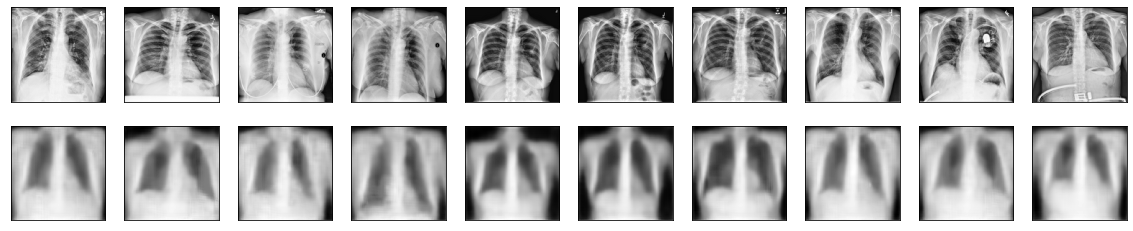

In [13]:
encode_only_imgs = encoder.predict(x_test[:10])
show_histo = False
if show_histo:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)

## Apply Shifter to Dataset

In [ ]:
use_rotation, use_shear = False, False
dump = False
weight_prior = 1.0/1000.0
count_imgs = 0

def xform_params(x):
    import math
    params = {'tx':x[0], 'ty':x[1], 'zx':math.exp(x[2]/30), 'zy':math.exp(x[3]/30)}
    if use_rotation:
        params['theta'] = x[4]
    if use_shear:
        params['shear'] = x[5]
    return params

def xform_image(params, img):
    from tensorflow.keras.preprocessing.image import apply_affine_transform as transform
    return transform(img, **params, fill_mode='nearest')

def xform_prior_logsq(x):
    theta_prior = x[0] * x[0]
    shear_prior = x[5] * x[5]
    scale_prior = x[3] * x[3] + x[4] * x[4]
    return theta_prior + shear_prior + scale_prior

def xformed_latent(x, img):
    params = xform_params(x)
    xformed = xform_image(params, img)
    latent_vector = encoder.predict([[xformed]])[2]
    # prior = xform_prior_logsq(x)
    return np.linalg.norm(latent_vector) # + weight_prior * prior
    
def shift(img):
    from scipy.optimize import minimize
    import pprint
    global count_imgs
    res = minimize(xformed_latent, np.zeros((4,)),
                   method='powell', 
                   # method='nelder-mead', 
                   args=img,
                   options={'xtol': 1e-6, 
                            'ftol': 1e-6,
                            # 'maxiter': 10000,
                            'disp': dump})
    params = xform_params(res.x)
    if dump:
        print(res)
        pprint.pprint(params)
    count_imgs = 1 + count_imgs
    print('{0}: {1},{2}'.format(count_imgs, res.x[0], res.x[1]), end = '\r')
    return xform_image(params, img)

x_train_shifted = []
for img in x_train:
    x_train_shifted.append(shift(img))
x_test_shifted = []
for img in x_test:
    x_test_shifted.append(shift(img))
show_original_decoded(x_test[:10], x_test_shifted[:10], sz)

In [26]:
x_train_shifted = np.array(x_train_shifted)
x_test_shifted = np.array(x_test_shifted)
x_train_shifted.shape, x_test_shifted.shape

((9000, 128, 128, 1), (1000, 128, 128, 1))

In [31]:
autoencoder.fit(x_train_shifted, x_train_shifted, 
                epochs=256, batch_size=128, 
                shuffle=True, validation_data=(x_test_shifted, x_test_shifted))

Train on 9000 samples, validate on 1000 samples
Epoch 1/256
9000/9000 [==============================] - 10s 1ms/step - loss: 277.1959 - val_loss: 299.1105
Epoch 2/256
9000/9000 [==============================] - 10s 1ms/step - loss: 276.9979 - val_loss: 327.8210
Epoch 3/256
9000/9000 [==============================] - 9s 1ms/step - loss: 278.0597 - val_loss: 310.2953
Epoch 4/256
9000/9000 [==============================] - 10s 1ms/step - loss: 276.5105 - val_loss: 306.0107
Epoch 5/256
9000/9000 [==============================] - 10s 1ms/step - loss: 277.6041 - val_loss: 306.1460
Epoch 6/256
9000/9000 [==============================] - 10s 1ms/step - loss: 277.4908 - val_loss: 303.4920
Epoch 7/256
9000/9000 [==============================] - 10s 1ms/step - loss: 277.9765 - val_loss: 319.0529
Epoch 8/256
9000/9000 [==============================] - 10s 1ms/step - loss: 278.4163 - val_loss: 338.3546
Epoch 9/256
9000/9000 [==============================] - 10s 1ms/step - loss: 276.0061 - 

Epoch 76/256
9000/9000 [==============================] - 10s 1ms/step - loss: 269.5515 - val_loss: 335.2994
Epoch 77/256
9000/9000 [==============================] - 10s 1ms/step - loss: 272.8233 - val_loss: 316.9714
Epoch 78/256
9000/9000 [==============================] - 10s 1ms/step - loss: 271.8842 - val_loss: 303.7137
Epoch 79/256
9000/9000 [==============================] - 10s 1ms/step - loss: 269.8994 - val_loss: 315.3081
Epoch 80/256
9000/9000 [==============================] - 10s 1ms/step - loss: 270.6232 - val_loss: 330.1169
Epoch 81/256
9000/9000 [==============================] - 10s 1ms/step - loss: 270.5539 - val_loss: 303.1043
Epoch 82/256
9000/9000 [==============================] - 10s 1ms/step - loss: 270.3670 - val_loss: 318.1328
Epoch 83/256
9000/9000 [==============================] - 10s 1ms/step - loss: 271.6186 - val_loss: 299.2145
Epoch 84/256
9000/9000 [==============================] - 10s 1ms/step - loss: 270.7276 - val_loss: 298.2214
Epoch 85/256
9000/9

9000/9000 [==============================] - 10s 1ms/step - loss: 262.9641 - val_loss: 312.5473
Epoch 225/256
9000/9000 [==============================] - 10s 1ms/step - loss: 263.9653 - val_loss: 302.5955
Epoch 226/256
9000/9000 [==============================] - 10s 1ms/step - loss: 264.1832 - val_loss: 303.9424
Epoch 227/256
9000/9000 [==============================] - 10s 1ms/step - loss: 263.6057 - val_loss: 302.8916
Epoch 228/256
9000/9000 [==============================] - 10s 1ms/step - loss: 263.5060 - val_loss: 318.4900
Epoch 229/256
9000/9000 [==============================] - 10s 1ms/step - loss: 264.2189 - val_loss: 300.9047
Epoch 230/256
9000/9000 [==============================] - 10s 1ms/step - loss: 263.5542 - val_loss: 294.6101
Epoch 231/256
9000/9000 [==============================] - 10s 1ms/step - loss: 263.5841 - val_loss: 314.9882
Epoch 232/256
9000/9000 [==============================] - 10s 1ms/step - loss: 263.6560 - val_loss: 317.1362
Epoch 233/256
9000/9000 

<IPython.core.display.Javascript object>


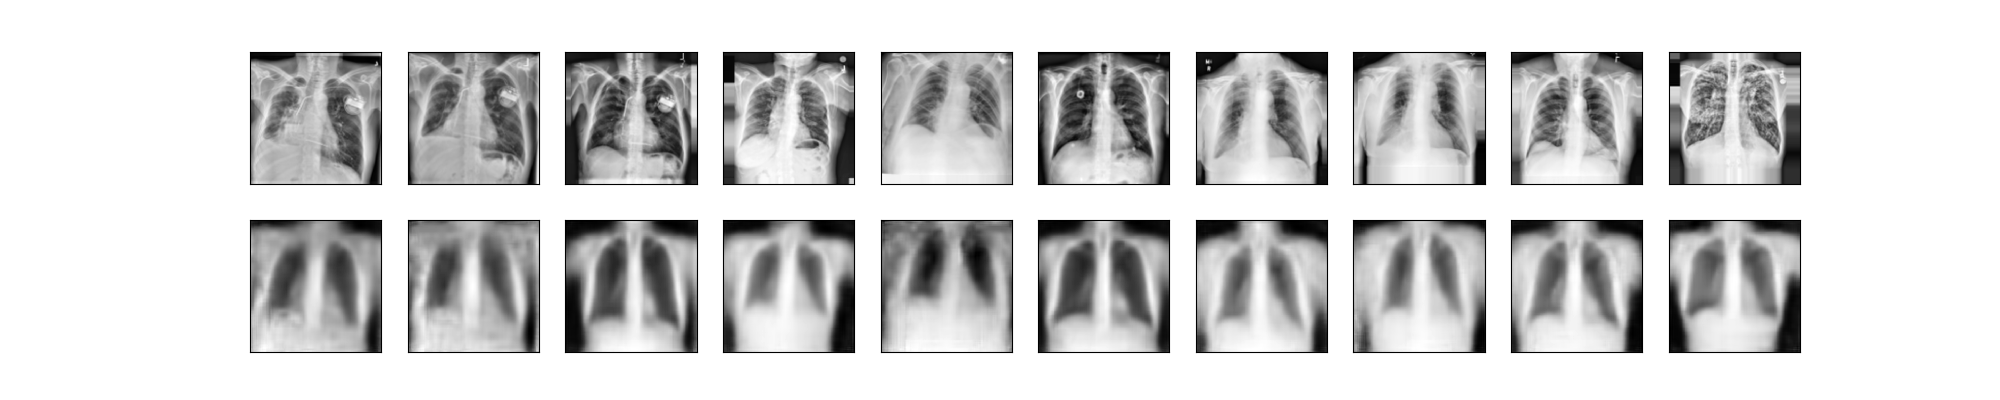

In [32]:
encoded_shift = encoder.predict(x_test_shifted[20:30])
decoded_imgs_shift = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encoded_shift[2]]
show_original_decoded(x_test_shifted[20:30], decoded_imgs_shift, sz)

## Saving the Model
If the model output looks good, then save it for subsequent use

In [18]:
encoder.save('data\zebrastack_v0_covidnet_encoder_model')
decoder.save('data\zebrastack_v0_covidnet_decoder_model')

## Anat0Mixer Interaction

In [29]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decoder, tuple(kwargs.values()))
    interp_array = decoded_pixel_array.reshape(sz,sz)
    # interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=0)
    # interp_array = interp_array.reshape(sz*4, sz*4)
    ax.imshow(interp_array, cmap='gray')
    fig.canvas.draw()
    return kwargs['1']

<IPython.core.display.Javascript object>


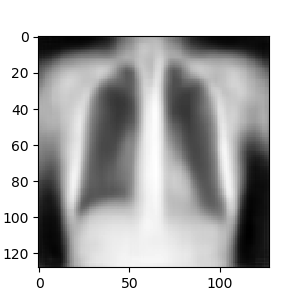

Output(layout=Layout(height='350px'))

In [33]:
%matplotlib notebook
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}

for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)
